# 1. Preparación del Ambiente

## Importaciones de librerias


In [1]:
import pandas as pd
#from ydata_profiling import ProfileReport

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
#from num2words import num2words
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import joblib
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\IsabellaLozano/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\IsabellaLozano/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Carga de Datos

In [2]:
df_original = pd.read_csv(r'C:\Users\IsabellaLozano\OneDrive - Universidad de los andes\universidad\Sexto Semestre\Inteligencia de Negocios\Proyecto 1\Proyecto1-BI\Etapa 1\datos\fake_news_spanish.csv', sep=';', encoding='utf-8')
df_original.head()

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018


In [3]:
train = df_original.copy()
train.head()

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018


# 2. Calidad de Datos

Se van a analizar 4 dimensiones distintas con respecto a la calidad de los datos (Completitud, Validez, Unicidad y Consistencia)

## Completitud

Luego de una breve inspección, se encuentra 16 valores nulos en la variable "Titulo" lo cual afecta la completitud en los datos.

In [4]:
train.isnull().sum()


ID              0
Label           0
Titulo         16
Descripcion     0
Fecha           0
dtype: int64

In [5]:
train.count()

ID             57063
Label          57063
Titulo         57047
Descripcion    57063
Fecha          57063
dtype: int64

In [6]:
train['Label'].value_counts()

Label
1    33158
0    23905
Name: count, dtype: int64

In [7]:
# strip all values in the column
train['Descripcion'] = train['Descripcion'].str.strip()
# count all values in the column where the value is an empty string
train['Descripcion'].isnull().sum()


0

## Validez

Hay un problema de codificación de los textos en el dataset (de la columna titulo y descripción), pues muchos caracteres que corresponden a vocales con tilde han sido reemplazados por caracteres no válidos.

In [8]:
def fix_encoding(text):
    replacements = {
        'Ã¡': 'á',
        'Ã©': 'é',
        'Ã­': 'í',
        'Ã³': 'ó',
        'Ãº': 'ú',
        'Ã±': 'ñ'
    }
    
    for wrong, correct in replacements.items():
        text = text.replace(wrong, correct)
    
    return text

train['Descripcion'] = train['Descripcion'].apply(fix_encoding)


convertir la columna Titulo de float a string para poder aplicar los cabios de fix_encoding

In [9]:
# Convertir la columna "Titulo" de float a string
train["Titulo"] = train["Titulo"].astype(str)

# Verificar el cambio de tipo de dato
train.dtypes["Titulo"]

dtype('O')

In [10]:
train['Titulo'] = train['Titulo'].apply(fix_encoding)


In [11]:
train.head(5)

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018


## Unicidad

En primera instancia, el dataset no tiene columnas que deban ser únicas siguiento algúna restricción de negocio. Bajo una inspección sencilla, parece haber filas totalmente duplicadas (445 datos completamente iguales).

In [12]:
train.duplicated().sum()

445

## Consistencia

La columna "ID" no es completamente única, lo que indica posibles inconsistencias

In [13]:
train["ID"].nunique() == len(train)

False

# Perfilamiento de los datos

Eliminacion de datos duplicados 

In [14]:
train.drop_duplicates(inplace=True)

In [15]:
train.count()

ID             56618
Label          56618
Titulo         56618
Descripcion    56618
Fecha          56618
dtype: int64

In [16]:
def mostrar_grafico1(palabras,stopwords=[]):
    comment_words = ''
    
    # iterate through the csv file
    for val in palabras:
        
        # typecaste each val to string
        val = str(val)
    
        # split the value
        tokens = val.split()
        
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        
        comment_words += " ".join(tokens)+" "
    
    
    wordcloud = WordCloud(width = 600, height = 600,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)
    
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0)
    
    plt.show()

Acontinuación se va a ilustrar que palabras suelen repetirse y encontrarse en los Label's 0 y 1

---------- Words for class: 1 ----------


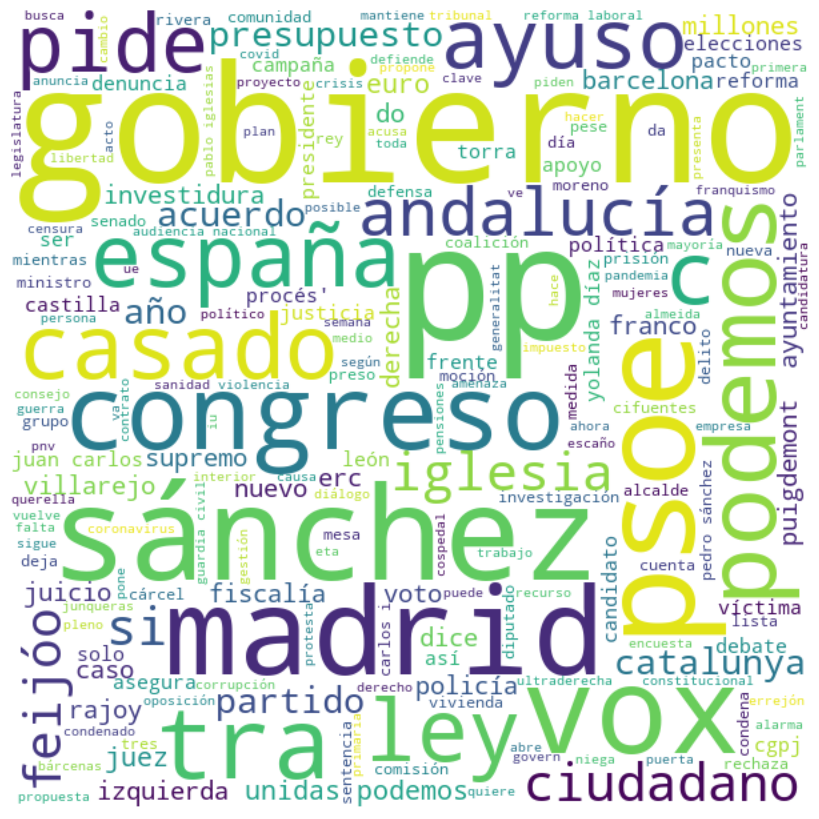

---------- Words for class: 0 ----------


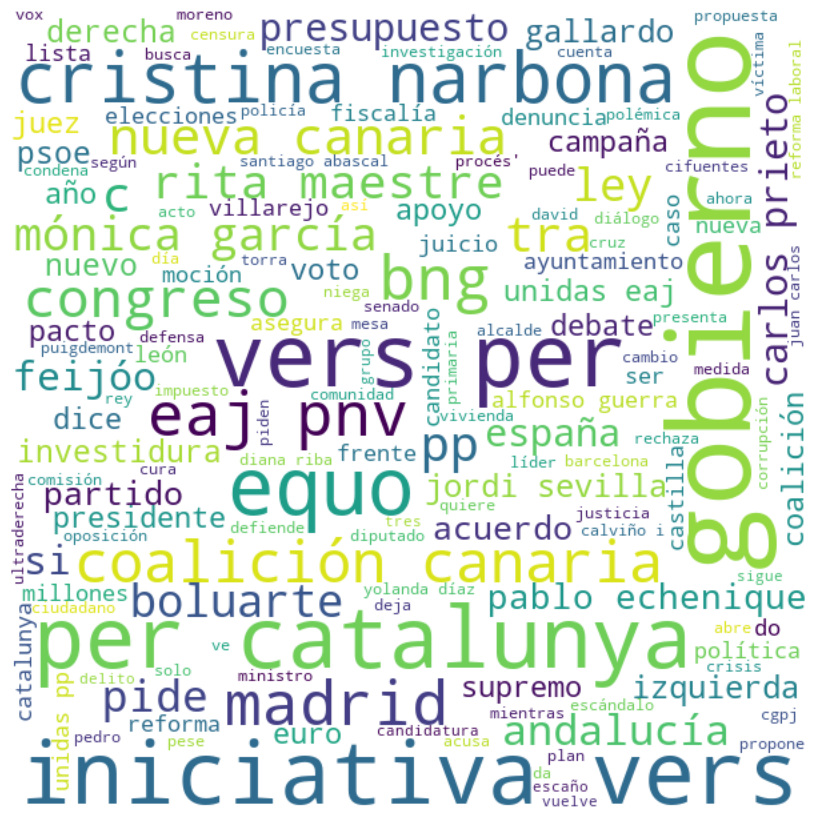

In [17]:
stop_words = set(nltk.corpus.stopwords.words('spanish'))

for i in train['Label'].unique():
    print(f'---------- Words for class: {i} ----------')
    mostrar_grafico1(train.loc[train['Label']==i,'Titulo'], stopwords=stop_words)

In [18]:
train

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018
...,...,...,...,...,...
57058,ID,1,El Defensor del Pueblo reclama a la Comunidad ...,El gobierno regional han indicado que la atenc...,08/06/2021
57059,ID,0,El EQUO plantea ceder la presidencia de la Com...,Si la higiene democrática nos lleva a esa exig...,08/09/2020
57060,ID,1,Alberto Garzón: 'Que los Borbones son unos lad...,El coordinador federal de IU asegura que la mo...,12/07/2018
57061,ID,1,Vox exige entrar en el Gobierno de Castilla y ...,Santiago Abascal: Vox tiene el derecho y el de...,13/02/2022


# Preparación de Datos


In [19]:
X_train, y_train = train['Titulo'], train['Label'] 
display(X_train)
y_train

0        'The Guardian' va con Sánchez: 'Europa necesit...
1        REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...
2        El 'Ahora o nunca' de Joan Fuster sobre el est...
3        Iglesias alienta a Yolanda Díaz, ERC y EH Bild...
4        Puigdemont: 'No sería ninguna tragedia una rep...
                               ...                        
57058    El Defensor del Pueblo reclama a la Comunidad ...
57059    El EQUO plantea ceder la presidencia de la Com...
57060    Alberto Garzón: 'Que los Borbones son unos lad...
57061    Vox exige entrar en el Gobierno de Castilla y ...
57062    Unas 300 personas protestan contra la visita d...
Name: Titulo, Length: 56618, dtype: object

0        1
1        0
2        1
3        1
4        0
        ..
57058    1
57059    0
57060    1
57061    1
57062    1
Name: Label, Length: 56618, dtype: int64

## Modificación de caracteres

Se pasan todos los caracteres a minuscula, se eliminan los textos de puntuación y asi mismo las stop words (que suelen ser palabras como articulos y conectores)

1. Cambiar a minusculas

In [20]:
def to_lower(words: list[str]):
    return [word.lower() for word in words]

2. Quitar puntuación

In [21]:
def remove_punctuation(words: list[str]):
    return [word for word in words if word.isalnum()]

3. Eliminar StopWords

In [22]:
def remove_stopwords(words: list[str]):
    stopwords = set(nltk.corpus.stopwords.words('spanish'))
    return [word for word in words if word not in stopwords]


In [23]:
def preprocessing(words):
    words = to_lower(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words

Ahora se va a hacer un procedimiento de Tokenizacion para desglozar las palabras

In [24]:
new_X_train = X_train.apply(word_tokenize)
new_X_train = new_X_train.apply(preprocessing) 
new_X_train.head()

0    [guardian, va, sánchez, necesita, apuesta, dé,...
1    [revelan, gobierno, negocio, liberación, mirel...
2    [nunca, joan, fuster, estatuto, valenciano, cu...
3    [iglesias, alienta, yolanda, díaz, erc, eh, bi...
4    [puigdemont, ninguna, tragedia, repetición, el...
Name: Titulo, dtype: object

Ahora, vamos a normalizar los datods. Para la normalización de los datos se realiza unicamente una lemmatización de los verbos. Puesto que se probo realizar de misma forma la estematización (eliminación de prefijos y sufijos) junto con la lemmatización y solo la estematización. El mejor resultado de normalización lo obtuvo solo realizar la lemmatización.

In [25]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = SnowballStemmer('spanish')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

In [26]:

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas


In [27]:
def stem_and_lemmatize(words):
    #words = stem_words(words)
    words = lemmatize_verbs(words)
    return words

In [28]:
new_X_train = new_X_train.apply(stem_and_lemmatize) 
new_X_train.head()

0    [guardian, va, sánchez, necesita, apuesta, dé,...
1    [revelan, gobierno, negocio, liberación, mirel...
2    [nunca, joan, fuster, estatuto, valenciano, cu...
3    [iglesias, alienta, yolanda, díaz, erc, eh, bi...
4    [puigdemont, ninguna, tragedia, repetición, el...
Name: Titulo, dtype: object

In [29]:
def concatenar (words):
    return ' '.join(words)

new_X_train = new_X_train.apply(concatenar)
new_X_train.head()

0       guardian va sánchez necesita apuesta dé frutos
1    revelan gobierno negocio liberación mireles ca...
2    nunca joan fuster estatuto valenciano cumple 4...
3    iglesias alienta yolanda díaz erc eh bildu neg...
4    puigdemont ninguna tragedia repetición elecciones
Name: Titulo, dtype: object

Por últmo se va a vectorizar las palabras para pasarle esta información al modelo.

Se decidio hacer una vectorización Tfidf de los datos puesto que esta vectorización funciona mejor en tareas de clasificación de textos, ya que destaca mejor las palabras importantes en el contexto de clasificación.

Además también se hicieron pruebas con otras vectorizaciones y esta dio el mejor resultado.

In [30]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(new_X_train)

print(X_tfidf.shape)
X_tfidf

(56618, 24024)


<56618x24024 sparse matrix of type '<class 'numpy.float64'>'
	with 490747 stored elements in Compressed Sparse Row format>

# Modelo KNN


## 1. Entrenar el modelo

In [31]:
X = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
X.head()
X_train = X
X_train

,000,016,021,024,061,10,100,1001,101,102,...,últimas,último,últimos,única,únicamente,únicas,único,únicos,útil,útiles
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
X_train.isnull().sum()


000       0
016       0
021       0
024       0
061       0
         ..
únicas    0
único     0
únicos    0
útil      0
útiles    0
Length: 24024, dtype: int64

In [33]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

best_n = 1
best_accuracy = 0
act_accuracy = 0
resultados = []

for i in range(1, 99, 2):
    if i % 3 == 0:
        print(f"Actualmente probando con {i} neighbors")
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train2, y_train2)
    y_pred = knn.predict(X_test2)
    act_accuracy = accuracy_score(y_test2, y_pred)
    resultados.append((i,act_accuracy))
    if act_accuracy > best_accuracy:
        best_accuracy = act_accuracy
        best_n = i

print(f'Best accuracy: {best_accuracy} with n_neighbors: {best_n}')

Actualmente probando con 3 neighbors
Actualmente probando con 9 neighbors
Actualmente probando con 15 neighbors
Actualmente probando con 21 neighbors
Actualmente probando con 27 neighbors
Actualmente probando con 33 neighbors
Actualmente probando con 39 neighbors
Actualmente probando con 45 neighbors
Actualmente probando con 51 neighbors
Actualmente probando con 57 neighbors
Actualmente probando con 63 neighbors
Actualmente probando con 69 neighbors
Actualmente probando con 75 neighbors
Actualmente probando con 81 neighbors
Actualmente probando con 87 neighbors
Actualmente probando con 93 neighbors
Best accuracy: 0.7932709290003532 with n_neighbors: 85


In [34]:
# Ordenar los resultados por precisión de mayor a menor
resultados.sort(key=lambda x: x[1], reverse=True)

# Obtener los 5 mejores valores de n_neighbors y sus precisiones
top_5 = resultados[:5]

# Imprimir los 5 mejores resultados
for n, accuracy in top_5:
    print(f"n_neighbors: {n}, accuracy: {accuracy:.4f}")

n_neighbors: 85, accuracy: 0.7933
n_neighbors: 83, accuracy: 0.7920
n_neighbors: 87, accuracy: 0.7920
n_neighbors: 71, accuracy: 0.7919
n_neighbors: 89, accuracy: 0.7919


In [35]:
knn = KNeighborsClassifier(n_neighbors=best_n)
knn.fit(X_train2, y_train2)
y_pred = knn.predict(X_test2)

In [36]:
# Calculate the accuracy
print(accuracy_score(y_test2, y_pred))

print(classification_report(y_test2, y_pred))

0.7932709290003532
              precision    recall  f1-score   support

           0       0.91      0.57      0.70      4844
           1       0.75      0.96      0.84      6480

    accuracy                           0.79     11324
   macro avg       0.83      0.77      0.77     11324
weighted avg       0.82      0.79      0.78     11324



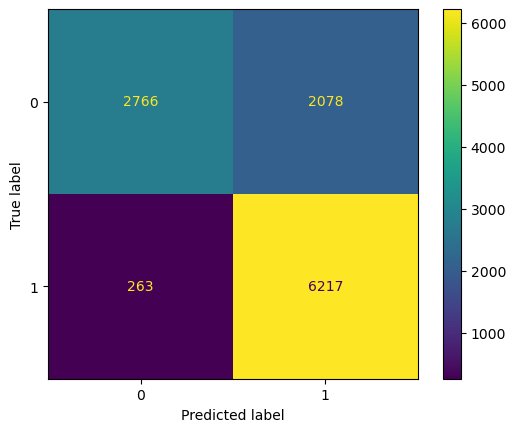

In [37]:
cm = confusion_matrix(y_test2, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()

# Pipeline

1. Strip

In [38]:
def strip_text(X):
    return X.str.strip()

2. Arreglar encoding

In [39]:
def replace(text):
    replacements = {
        'Ã¡': 'á',
        'Ã©': 'é',
        'Ã­': 'í',
        'Ã³': 'ó',
        'Ãº': 'ú',
        'Ã±': 'ñ'
    }
    for wrong, correct in replacements.items():
        text = text.replace(wrong, correct)
    return text

In [40]:
def fix_encoding_array(X):
    return X.apply(replace)

3. Preprocessing

In [41]:
def to_lower(words: list[str]):
    return [word.lower() for word in words]

In [42]:
def remove_punctuation(words: list[str]):
    return [word for word in words if word.isalpha()]

In [43]:
def remove_stopwords(words: list[str]):
    stopwords = set(nltk.corpus.stopwords.words('spanish'))
    return [word for word in words if word not in stopwords]

In [44]:
def remove_numbers(words: list[str]):
    return [word for word in words if not word.isdigit()]


In [45]:
def preprocessing(words: list[str]):
    words = to_lower(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = remove_numbers(words)
    return words

In [46]:
def preprocessing_array(X):
    return X.apply(preprocessing)


4. Tokenize

In [47]:
def word_tokenize_spanish(text):
    return word_tokenize(text, language='spanish')

In [48]:
def word_tokenize_spanish_array(X):
    X = X.apply(word_tokenize_spanish)
    return X

5. Lemmatize

In [49]:
def lemmatize(words):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

In [50]:
def lemmatize_array(X):
    X = X.apply(lemmatize)
    return X

6. Concatenar palabras

In [51]:
def concat_words(words):
    return ' '.join(map(str, words))

In [52]:
def concat_words_array(X):
    return X.apply(concat_words)

7. Pipeline

In [53]:
preprocessing_pipeline = Pipeline([
    ('strip', FunctionTransformer(strip_text)),
    ('fix_encoding', FunctionTransformer(fix_encoding_array)),
    ('tokenize', FunctionTransformer(word_tokenize_spanish_array)),
    ('preprocessing', FunctionTransformer(preprocessing_array)),
    ('lemmatize', FunctionTransformer(lemmatize_array)),
    ('concat', FunctionTransformer(concat_words_array))
])

In [54]:
vectorization_clf_pipeline = Pipeline([
    ('b_o_w', TfidfVectorizer()),
    ('clf', KNeighborsClassifier())
])

In [55]:
pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('vectorization_clf', vectorization_clf_pipeline)
])

## Prueba al Pipeline

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    train["Titulo"], train["Label"], test_size=0.2, random_state=42
)
y_pred_test = pipeline.fit(X_train, y_train).predict(X_test)
print(accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

0.6595725891910985
              precision    recall  f1-score   support

           0       0.69      0.37      0.48      4844
           1       0.65      0.87      0.75      6480

    accuracy                           0.66     11324
   macro avg       0.67      0.62      0.62     11324
weighted avg       0.67      0.66      0.63     11324



1. Búsqueda de un hiperparámetro con Grid Search

In [57]:
kfold = KFold(n_splits=10, shuffle=True, random_state=0)

X = train["Titulo"]
X = preprocessing_pipeline.transform(X)
y = train["Label"]
scores = cross_val_score(vectorization_clf_pipeline, X, y, cv=kfold)

print(scores)
print(f"Scores mean: {scores.mean()}")

[0.67078771 0.65913105 0.65489226 0.66248675 0.64411869 0.64888732
 0.66584246 0.65895443 0.64458576 0.6611906 ]
Scores mean: 0.6570877035740834


Para el grid search se implementan los 5 neighbors con mejor precision encontrados previamente

In [61]:
param_grid = {
    'clf__n_neighbors': [71, 83, 87, 85, 89],
    'clf__p': [1, 2], #Función de distancia 1: manhattan, 2: euclidean
    'clf__weights': ['uniform', 'distance'],
    'b_o_w__min_df': [0.0, 0.1, 0.2],
    'b_o_w__max_df': [1.0, 0.9, 0.8]
}

In [62]:
X = train["Titulo"]
y = train["Label"]


In [63]:
X = preprocessing_pipeline.transform(X)


In [64]:
grid_search = GridSearchCV(vectorization_clf_pipeline, param_grid, cv=5, n_jobs=-1, verbose=2)

In [65]:
grid_search.fit(X, y)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


c:\Users\IsabellaLozano\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
300 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\IsabellaLozano\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\IsabellaLozano\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\IsabellaLozano\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 46

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('b_o_w', TfidfVectorizer()),
                                       ('clf', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'b_o_w__max_df': [1.0, 0.9, 0.8],
                         'b_o_w__min_df': [0.0, 0.1, 0.2],
                         'clf__n_neighbors': [71, 83, 87, 85, 89],
                         'clf__p': [1, 2],
                         'clf__weights': ['uniform', 'distance']},
             verbose=2)

In [66]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Best parameters: {'b_o_w__max_df': 1.0, 'b_o_w__min_df': 0.0, 'clf__n_neighbors': 85, 'clf__p': 2, 'clf__weights': 'uniform'}
Best cross-validation score: 0.7964


3. Correción del Pipeline con los hiperparámetros


In [67]:
vectorization_clf_pipeline_hiperparametros = Pipeline([
    ('b_o_w', TfidfVectorizer(min_df=0.0, max_df=1.0)),
    ('clf', KNeighborsClassifier(n_neighbors=46, p=2, weights='distance'))
])

pipeline_final = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('vectorization_clf', vectorization_clf_pipeline_hiperparametros)
])

In [68]:
X_train, X_test, y_train, y_test = train_test_split(train["Titulo"], train["Label"], test_size=0.2, random_state=42)
y_pred_test = pipeline_final.fit(X_train, y_train).predict(X_test)

0.7932709290003532
              precision    recall  f1-score   support

           0       0.91      0.57      0.70      4844
           1       0.75      0.96      0.84      6480

    accuracy                           0.79     11324
   macro avg       0.83      0.77      0.77     11324
weighted avg       0.82      0.79      0.78     11324



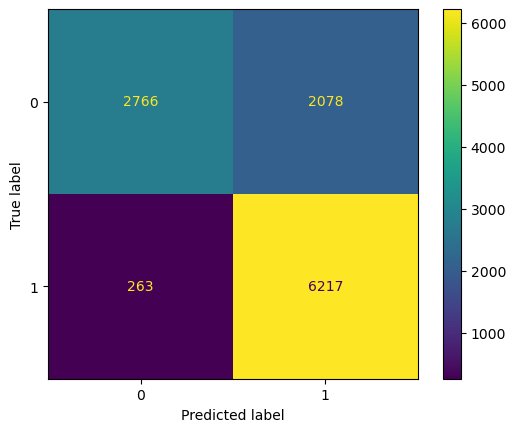

In [69]:
# Calculate the accuracy
print(accuracy_score(y_test2, y_pred))

print(classification_report(y_test2, y_pred))
cm = confusion_matrix(y_test2, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()

## Serializar modelo

In [70]:
# Serialize model
joblib.dump(pipeline_final, 'pipeline_modelo_knn.joblib')

['pipeline_modelo_knn.joblib']